# Use a Recurrent Neural Net to find Baby Names

I need a good name for a baby!  It should be unique, but not too weird.  Use an RNN to find some plausible baby names that have never been used.

First get some baby names from the social security administration:

In [1]:
!wget https://www.ssa.gov/oact/babynames/names.zip

--2018-03-19 20:47:10--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.4.16, 2001:1930:d07::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.4.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8207194 (7.8M) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]   7.83M   496KB/s    in 2m 29s  

2018-03-19 20:49:40 (53.6 KB/s) - ‘names.zip’ saved [8207194/8207194]



Next, extract the name info:

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('./names.zip', 'r')
zip_ref.extractall('./names/')
zip_ref.close()

Load some libraries, print out the versions:

In [3]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
np.random.seed(8675309)
%matplotlib notebook
%load_ext version_information
%version_information pandas, numpy, keras, matplotlib

/home/jak/miniconda3/envs/keras_tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Software versions
Python 3.6.4 64bit [GCC 7.2.0]
IPython 6.2.1
OS Linux 4.13.0 36 generic x86_64 with debian stretch sid
pandas 0.22.0
numpy 1.14.2
keras 2.1.5
matplotlib 2.2.2
Mon Mar 19 20:49:42 2018 EDT

Read in the name files:

In [4]:
master = pd.DataFrame()
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Fraction'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum())
    master=master.append(dat)

gender=master.groupby('Gender')
boys = gender.get_group('M').sort_values('Year')
girls = gender.get_group('F').sort_values('Year')

Next, inspect the data 

In [5]:
print(master.sample(20))


           Name Gender  Count  Year  Fraction
12895     kaleb      M    144  1984  0.000080
6532    carlyle      M     75  1925  0.000067
16197   demarko      M     26  1988  0.000014
1731     mitsue      F     25  1925  0.000021
7867   charlton      M     17  1948  0.000010
27589  jamaurie      M     11  2009  0.000006
24152    walden      M     21  2012  0.000011
8556    josalin      F     13  2005  0.000007
4922    cherese      F      8  1962  0.000004
1258      kasey      F     73  1965  0.000041
1573   laquanda      F     75  1982  0.000044
6907     felipe      M    183  1952  0.000094
3330       lova      F      8  1935  0.000008
21065     peder      M     11  1993  0.000006
16046      nhan      M     15  1986  0.000008
8956       jaye      M      8  1949  0.000005
1891    suzanna      F    100  2004  0.000055
24443    winson      M     16  2005  0.000008
6921      nihal      F     18  2013  0.000010
9207      umeko      F      9  1990  0.000005


# Inspect some names over time

<IPython.core.display.Javascript object>


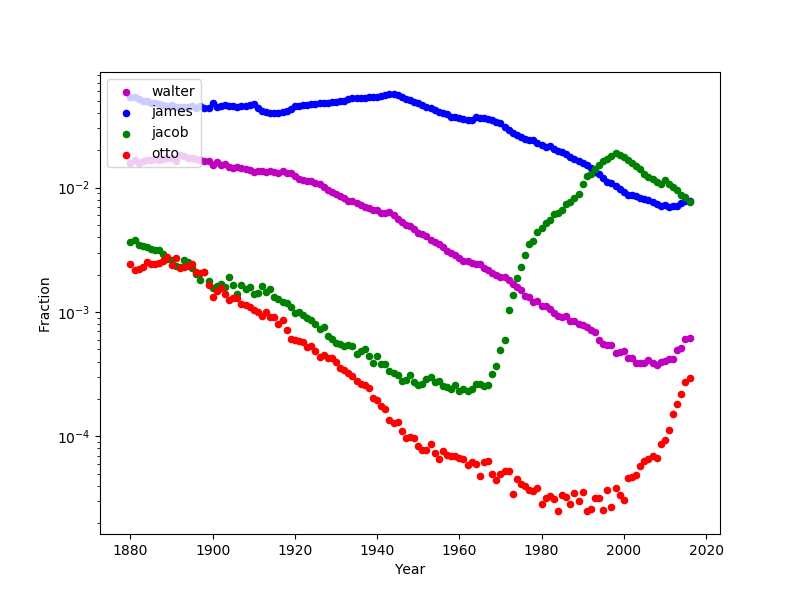

In [14]:
%matplotlib notebook
names=['walter','james','jacob','otto']
colors=['m','b','g','r']
plt.figure(figsize=(8,6))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=boys[boys['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

<IPython.core.display.Javascript object>


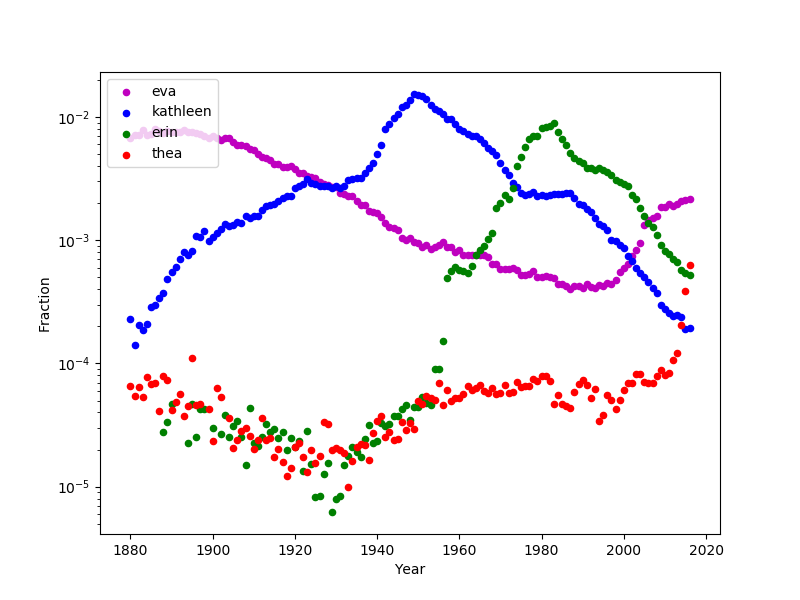

In [15]:
%matplotlib notebook
names=['eva','kathleen','erin','thea']
colors=['m','b','g','r']
plt.figure(figsize=(8,6))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=girls[girls['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

Find names that are <0.05% but have been increasing recently and are short

In [8]:
namesnow = girls.loc[(girls.Fraction<1e-3)& (girls.Fraction>1e-4)&((girls.Year==2016) |(girls.Year==2013)) ,:]

name_piv = pd.pivot_table(namesnow,values='Fraction',index=['Name'],columns=['Year'])
name_piv['Delta']=(name_piv[2016]-name_piv[2013])/name_piv[2016]
promising = name_piv.Delta.nlargest(30)

print(promising.loc[promising.index.str.len()<7])


Name
thea      0.807795
freya     0.715218
remi      0.711081
aviana    0.648063
margot    0.637247
ariah     0.627236
saylor    0.611804
amina     0.591874
maisie    0.591520
lennon    0.577528
carter    0.570391
ariyah    0.565308
zelda     0.564787
river     0.564308
adley     0.541589
amara     0.538825
poppy     0.523006
jessa     0.517731
blake     0.506577
milani    0.495600
Name: Delta, dtype: float64


For fun, how many girls names are palindromes?

In [9]:
def is_palindrome(s):
    return(str(s) == str(s)[::-1])

p=girls.Name.copy().map(is_palindrome).values
girls.loc[p,:].groupby(['Name']).agg('median').sort_values('Fraction',ascending=False).sample(10)

,Count,Year,Fraction
Name,,,
nin,6.0,1998.0,0.000003
afifa,6.0,2007.5,0.000003
ara,19.0,1948.0,0.000016
lil,6.5,1957.5,0.000004
rever,7.0,1921.5,0.000006
anna,5429.0,1948.0,0.004743
ireri,6.5,2005.0,0.000003
ede,5.0,1959.0,0.000003
emme,84.0,2002.5,0.000045


# Train the Recurrent Neural Net

Ok, get to work: build RNN model for girl's names using the Keras text generation [example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py) as a starting point:

In [10]:
# blatant steal from : https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
np.random.seed(8675309)

text = ' '.join(girls['Name'].values)
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 12
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 10):
    results=model.fit(X, y,
              batch_size=128,
              epochs=1,
              verbose=0)
    print('Iteration: {}, Loss: {:3.2f}'.format(iteration,results.history['loss'][0]))


corpus length: 8172527
total chars: 27
nb sequences: 2724172
Vectorization...
Build model...
Iteration: 1, Loss: 1.63
Iteration: 2, Loss: 1.61
Iteration: 3, Loss: 1.68
Iteration: 4, Loss: 1.70
Iteration: 5, Loss: 1.74
Iteration: 6, Loss: 1.72
Iteration: 7, Loss: 1.72
Iteration: 8, Loss: 1.69
Iteration: 9, Loss: 1.70


With the trained model, generate some predictions, then use `set` to find names that are not in the training set:

In [11]:
np.random.seed(8675309)
generated=''
diversity=0.5
sentence='sweet peanut'  # seed text to kick off predictions
for i in range(40000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    
names = set(generated.split(' '))-set(girls['Name'])

/home/jak/miniconda3/envs/keras_tf/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


In [12]:
len(names)

939

And here are the new unique names:

In [13]:
' '.join(sorted([n for n in names if len(n)<7 and len(n)>2]))

'alagy alen alenor aleve alexal aleyn alian alisie alisy allian allin alnis alocia aloka alther aluma amarli amian amiana amilly amitte ammia amona anacha anada anaill anale analla anamer anamon anamy anane ananee ananel ananie anasta anaura anayya andran andrie anemi anerie anesta anhala anhika anito annada annaiy annana anoran anyana arana arcia areste areton arisla armin arolle arshan arver aryle atlann barbel barbia bebja bertla bethi breani brinie brittn caery camina carlor carlte cimina cyna dadrie daini dalan dalean daless dalian dalie damito dammia danal danam danan danana danane dancie danees dannai darger dariet darile darisa darja darmen darry dauane dauara dauia daula daunna daura dauria dayenn dayre dazira dear debbia dellen dellin dellis denan denana dener derie deshi destie detis dinie dobie dolin donana donena donill donnan doora dorne dylina dynora edrian eilie eima elexie eley eligan elises ellera elleu ellian ellish eloren emela emian emilla enaina enarle enena enett